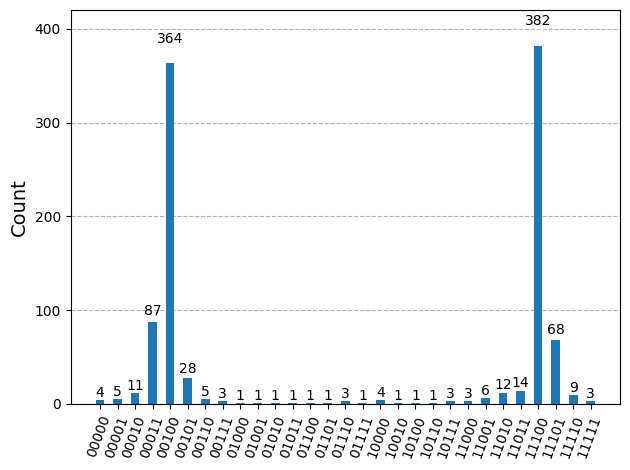

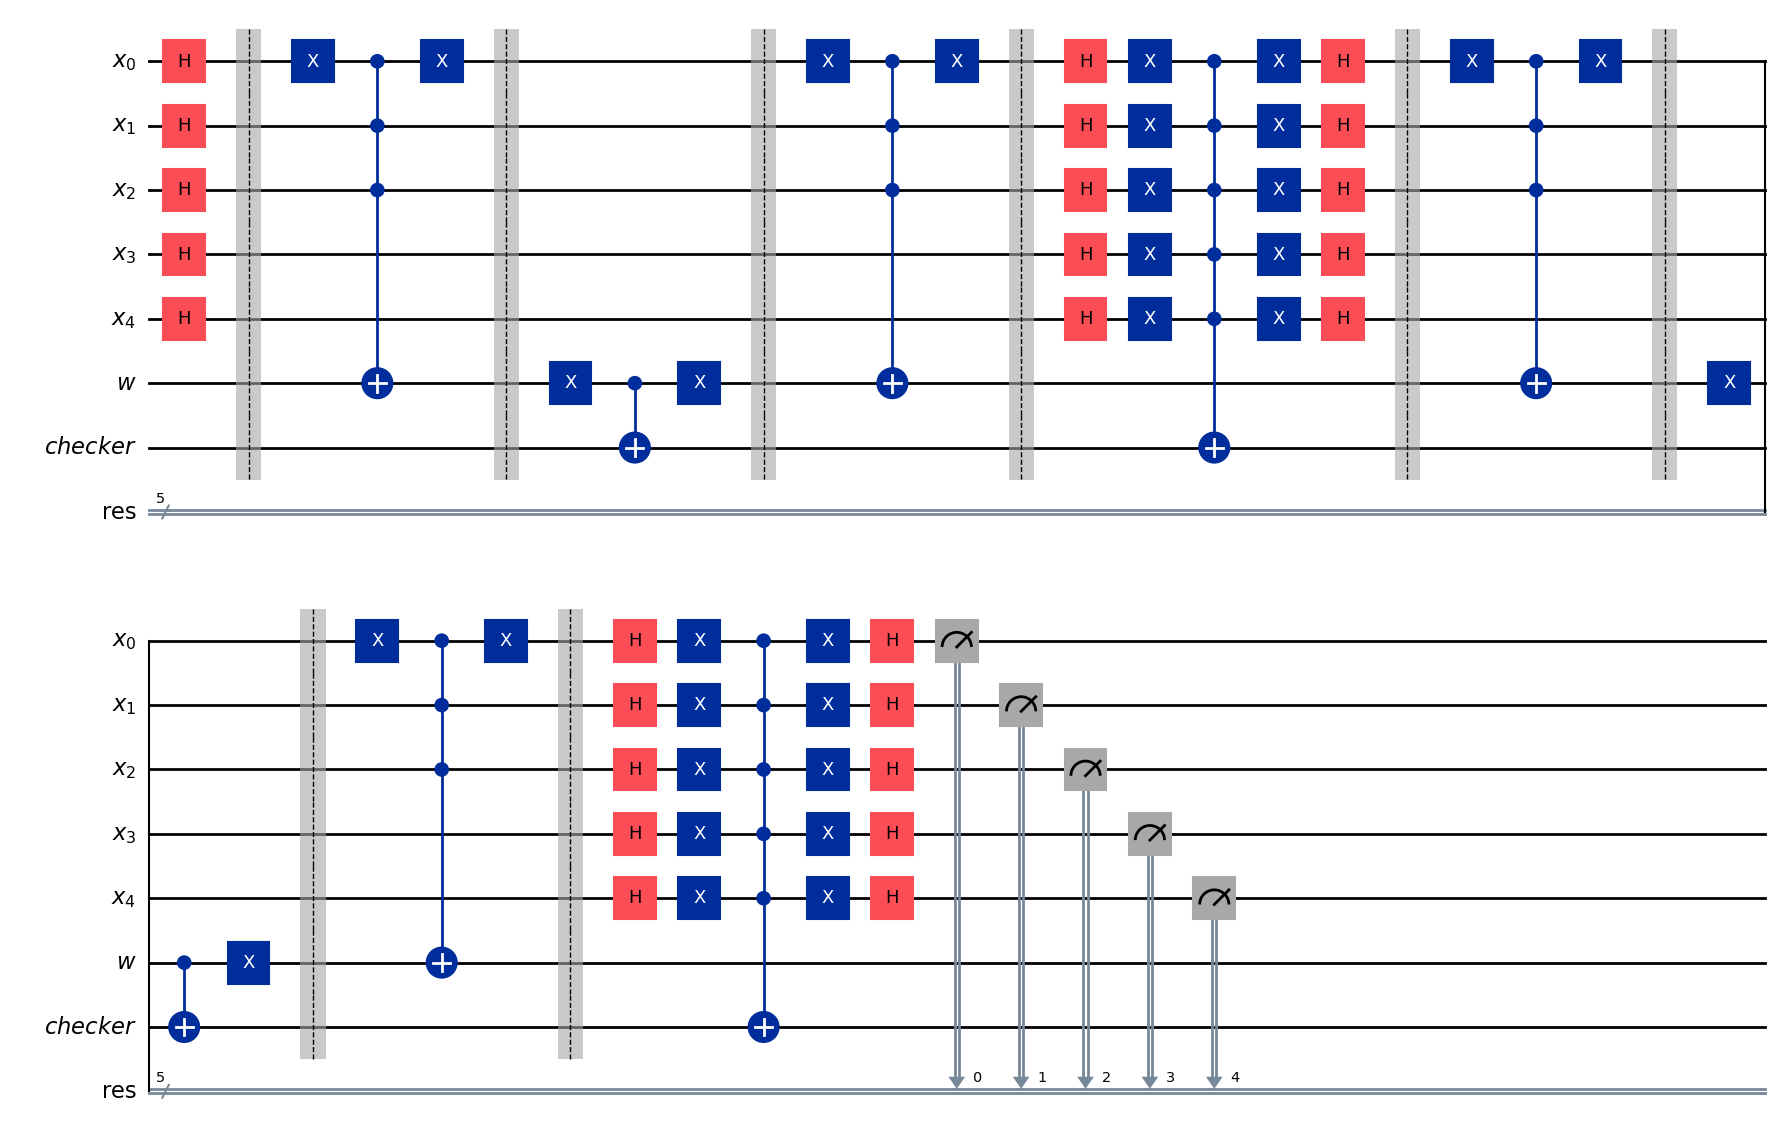

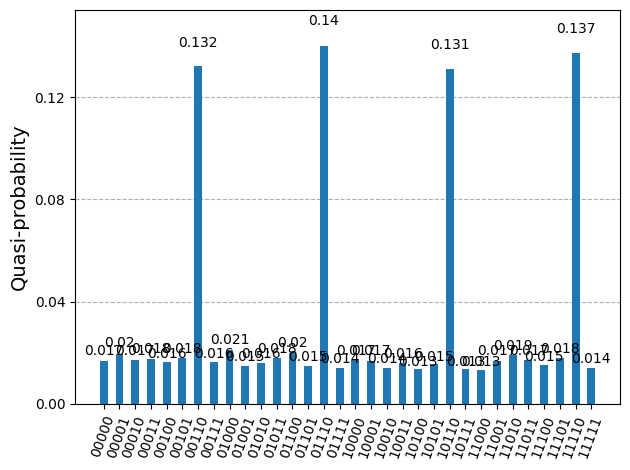

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import MCXGate, QFT
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from qiskit_aer import Aer
import math
%matplotlib inline

# NOTES
# Current version is based off of DNF expressions
def get_diffuser(n_var):
    qvar = QuantumRegister(n_var)
    qtarget = QuantumRegister(1)
    diffuser = QuantumCircuit(qvar, qtarget, name='diffuser')
    diffuser.h(qvar)
    diffuser.x(qvar)
    diffuser.append(MCXGate(len(qvar)), qvar[:] + qtarget[:])
    diffuser.x(qvar)
    diffuser.h(qvar)
    return diffuser

def get_oracle(n_var, expression):
    oq_n = QuantumRegister(n_var)
    oq_w = QuantumRegister(len(expression))
    oq_checker = QuantumRegister(1)
    oracle = QuantumCircuit(oq_n, oq_w, oq_checker, name='oracle')

    oracle.barrier()

    variables = [chr(97 + i) for i in range(n_var)]
    var_to_index = {var: i for i, var in enumerate(variables)}
    vars_used = {var: 0 for var in variables}

    length_list = []
    for i in range(len(expression)):
        clause = expr[i].split()
        for index, words in enumerate(clause):
            if words == "not":
                letter = clause[index + 1]
                oracle.x(oq_n[var_to_index[letter]])
                vars_used[letter] = 1
            elif (words in variables) and clause[index - 1] != "not":
                vars_used[words] = 1
        and_list = [oq_n[var_to_index[key]] for key, value in vars_used.items() if value == 1]
        length_list.append(len(and_list))
        and_list.append(oq_w[i])
        oracle.append(MCXGate(length_list[i]), and_list)
        for index, words in enumerate(clause):
            if words == "not":
                letter = clause[index + 1]
                oracle.x(oq_n[var_to_index[letter]])
                vars_used[letter] = 0
            elif (words in variables) and clause[index - 1] != "not":
                vars_used[words] = 0

    oracle.barrier()
    for i in range(len(expression)):
        oracle.x(oq_w[i])

    oracle.append(MCXGate(len(oq_w)), oq_w[:] + oq_checker[:])
    #oracle.x(oq_checker[0]) 
    #oracle.z(oq_checker[0])   
    #oracle.append(MCXGate(len(oq_w)), oq_w[:] + oq_checker[:])
 
    for i in range(len(expression)):
        oracle.x(oq_w[i])

    for i in range(len(expression)):
        oracle.barrier()
        clause = expr[len(expression) - i - 1].split()
        for index, words in enumerate(clause):
            if words == "not":
                letter = clause[index + 1]
                oracle.x(oq_n[var_to_index[letter]])
                vars_used[letter] = 1
            elif (words in variables) and clause[index - 1] != "not":
                vars_used[words] = 1
        and_list = [oq_n[var_to_index[key]] for key, value in vars_used.items() if value == 1]
        length_list.append(len(and_list))
        and_list.append(oq_w[len(expression) - i - 1])
        oracle.append(MCXGate(length_list[len(expression) - i - 1]), and_list)
        for index, words in enumerate(clause):
            if words == "not":
                letter = clause[index + 1]
                oracle.x(oq_n[var_to_index[letter]])
                vars_used[letter] = 0
            elif (words in variables) and clause[index - 1] != "not":
                vars_used[words] = 0
    oracle.barrier()
    return oracle

def createOracle(expression, qubits):
    var = [chr(97 + i) for i in range(qubits)]
    args = ", ".join(var)
    return eval(f"lambda {args}: {expression}")

def count_solutions(expression, qubits):
    oracle_func = createOracle(expression, qubits)
    count = 0
    for i in range(2**qubits):
        bits = [int(b) for b in f"{i:0{qubits}b}"]
        if oracle_func(*bits):
            count += 1
    return count

expr0 = "(not a and b and c)"
n = 5 # number of variables

conversion = expr0.split("or")
expr = [clause.strip().strip("() ") for clause in conversion]

m = len(expr)  # number of clauses

q_n = QuantumRegister(n, 'x')
q_w = QuantumRegister(m, 'w')
q_checker = QuantumRegister(1, 'checker')
c_n = ClassicalRegister(n, 'res')

sat_solver = QuantumCircuit(q_n, q_w, q_checker, c_n)
sat_solver.h(q_n)

#n_solutions = count_solutions(expr0, n)

t = n # number of counting qubits
phase_oracle = get_oracle(n, expr)
# phase_oracle.z(n+m)
# remove barriers from circuit
phase_oracle.data = [inst for inst in phase_oracle.data if inst.operation.name != "barrier"]
phase_diffuser = get_diffuser(n)

count_qubits = QuantumRegister(t, 'counting')
search_qubits = QuantumRegister(n + m + 1, 'searching')  
count_classical = ClassicalRegister(t)

qc = QuantumCircuit(count_qubits, search_qubits, count_classical)

qc.h(list(count_qubits) + list(search_qubits[:n]))

grover = QuantumCircuit(n + m + 1, name='Grover')
grover.compose(phase_oracle, qubits=range(n + m + 1), inplace=True)
grover.compose(phase_diffuser, qubits=list(range(n)) + [n + m], inplace=True)
grover_gate = grover.to_gate()

qc.x(search_qubits[-1])
qc.h(search_qubits[-1])

for i in range(t):
    n_iterations = 2**i
    powered_grover = grover_gate.repeat(n_iterations).control()
    qc.append(powered_grover, [count_qubits[i]] + search_qubits[:])
    #for _ in range(n_iterations):
        #ctrl_oracle = phase_oracle.control()
        #qc.append(ctrl_oracle, [count_qubits[i]] + list(work_qubits))
        
        #ctrl_diffuser = phase_diffuser.control()
        #qc.append(ctrl_diffuser, [count_qubits[i]] + list(work_qubits[:n]) + [work_qubits[-1]])
        
        #qc.append(controlled_grover, [count_qubits[i]] + search_qubits[:])

qft_dagger = QFT(t, inverse=True).to_gate()
qft_dagger.label = "QFT†"
qc.append(qft_dagger, range(t))

qc.measure(range(t), range(t))
#qc.draw('mpl')

simulator_qc = Aer.get_backend("aer_simulator")
shots =  8
transpiled_qc = transpile(qc, simulator_qc)
result = simulator_qc.run(transpiled_qc).result()
counts = result.get_counts()
plot_histogram(counts)

measured_str = max(counts, key=counts.get)
#print("Register Output = ",  measured_str)
measured_int = int(measured_str, 2)
#print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi*2
#print(f"Estimated theta: {theta}")

N = 2 ** n
M = N * (math.sin(theta/2)**2)
m = t - 1 #Will be less than this (out of scope) 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
#print("Error < %.2f" % err)

#print(f"Estimated number of solutions: {M}")
#print(f"Actual number of solutions: {n_solutions}")

iterations = math.floor(math.pi / 4 * math.sqrt(2**n / M))

oracle = get_oracle(n, expr)
diffuser = get_diffuser(n)

for _ in range(iterations):
    sat_solver.compose(oracle, qubits=q_n[:] + q_w[:] + q_checker[:], inplace=True)
    sat_solver.compose(diffuser, qubits=q_n[:] + q_checker[:], inplace=True)

sat_solver.measure(q_n, c_n)

sat_solver.draw('mpl')

simulator = Aer.get_backend('qasm_simulator')
shots = 4096
result = simulator.run(sat_solver, shots=shots).result()
counts = result.get_counts(sat_solver)
total_shots = sum(counts.values())
percentages = {outcome: count / total_shots * 100 for outcome, count in counts.items()}

plot_histogram(percentages)
plt.show()
